In [8]:
import numpy as np
import tensorflow as tf

mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [9]:
# 将图像数据展开为向量形式
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [10]:
def softmax(x):
    x = x.astype(np.float)
    xmax = np.max(x, axis=1, keepdims=True)
    e_x = np.exp(x - xmax)
    smax = np.sum(e_x, axis=1, keepdims=True)
    return e_x / smax


def CrossEntropy(predict, target):
    N = predict.shape[0]
    entropy = -np.log(predict[np.arange(N), target])
    return entropy

In [11]:
from tqdm import tqdm
import matplotlib.pyplot as plt


class TwoLayerModel:
    def __init__(self, hidden_size, input_size=784, output_size=10, std=1e-4):
        self.params = {'W1': std * np.random.randn(input_size, hidden_size), 'b1': np.zeros(hidden_size),
                       'W2': std * np.random.randn(hidden_size, output_size), 'b2': np.zeros(output_size)}
        self.patience = 5

    def forward(self, X):
        O = {'X': X}
        Y_1 = np.dot(X, self.params['W1']) + self.params['b1']
        o_1 = 1 / (1 + np.exp(-Y_1))
        Y_2 = np.dot(o_1, self.params['W2']) + self.params['b2']
        o_2 = softmax(Y_2)
        O['Y_1'], O['o_1'], O['Y_2'], O['o_2'] = Y_1, o_1, Y_2, o_2
        return O

    def loss_grad(self, X, y, reg):
        O = self.forward(X)
        Y_1, o_1, Y_2, o_2 = O['Y_1'], O['o_1'], O['Y_2'], O['o_2']
        N = X.shape[0]
        loss = np.sum(CrossEntropy(o_2, y)) / N
        dY_2 = o_2.copy()
        dY_2[np.arange(N), y] -= 1
        dY_2 /= N

        # backward
        dW2 = np.dot(o_1.T, dY_2)
        db2 = np.sum(dY_2, axis=0)
        do_1 = np.dot(dY_2, self.params['W2'].T)
        dY_1 = np.multiply(do_1, 1 - do_1)
        dW1 = np.dot(X.T, dY_1)
        db1 = np.sum(dY_1, axis=0)
        dW2 += reg * self.params['W2']
        dW1 += reg * self.params['W1']
        grads = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
        return loss, grads

    def train(self, X, y, reg, epochs=20, lr=0.5, lr_decay=0.95, batch_size=32):
        N, D = X.shape
        num_iter = N // batch_size
        avgl = []
        acc = []
        patience = 0
        best_val = 0
        for epoch in range(epochs):
            L = 0
            for i in tqdm(range(num_iter)):
                batch_indices = np.random.choice(N, batch_size, replace=True)
                X_batch = X[batch_indices]
                Y_batch = y[batch_indices]
                loss, grads = self.loss_grad(X_batch, Y_batch, reg)
                L += loss
                # 更新参数
                self.params['W1'] -= lr * grads['W1']
                self.params['b1'] -= lr * grads['b1']
                self.params['W2'] -= lr * grads['W2']
                self.params['b2'] -= lr * grads['b2']
                if not i % 1000:
                    lr *= lr_decay
            train_acc = (self.predict(X_test) == y_test).mean()
            patience += 1
            if train_acc > best_val:
                best_val = train_acc
                patience = 0
            elif patience >= self.patience:
                break
            L /= num_iter
            avgl.append(L)
            acc.append(train_acc)
            print(f"epoch {epoch} loss: {L}, train_acc {train_acc}")
        return avgl, acc

    def predict(self, X):
        o_2 = self.forward(X)['o_2']
        y_pred = np.argmax(o_2, axis=1)
        return y_pred

    def save(self, path):
        with open(path, 'w') as f:
            f.write(f'params: {self.params}')
            f.write("activate function: sigmoid")

  0%|          | 0/1875 [00:00<?, ?it/s]C:\Users\99480\AppData\Local\Temp\ipykernel_15332\3395470305.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.astype(np.float)
C:\Users\99480\AppData\Local\Temp\ipykernel_15332\1954188261.py:14: RuntimeWarning: overflow encountered in exp
  o_1 = 1 / (1 + np.exp(-Y_1))
100%|██████████| 1875/1875 [00:03<00:00, 532.55it/s]


epoch 0 loss: 0.4971771793851429, train_acc 0.8599


100%|██████████| 1875/1875 [00:04<00:00, 458.68it/s]


epoch 1 loss: 0.46829610647081465, train_acc 0.8583


100%|██████████| 1875/1875 [00:04<00:00, 457.79it/s]


epoch 2 loss: 0.44006867892368196, train_acc 0.8762


100%|██████████| 1875/1875 [00:04<00:00, 442.59it/s]


epoch 3 loss: 0.4166567067932247, train_acc 0.8816


100%|██████████| 1875/1875 [00:04<00:00, 443.45it/s]


epoch 4 loss: 0.39859965120635227, train_acc 0.881


100%|██████████| 1875/1875 [00:04<00:00, 430.95it/s]


epoch 5 loss: 0.3992938551591004, train_acc 0.8895


100%|██████████| 1875/1875 [00:04<00:00, 457.45it/s]


epoch 6 loss: 0.3877136070120205, train_acc 0.8883


100%|██████████| 1875/1875 [00:04<00:00, 446.47it/s]


epoch 7 loss: 0.404282563557176, train_acc 0.8845


100%|██████████| 1875/1875 [00:04<00:00, 447.89it/s]


epoch 8 loss: 0.4207726526637897, train_acc 0.8851


100%|██████████| 1875/1875 [00:03<00:00, 542.21it/s]


epoch 9 loss: 0.4283194073093842, train_acc 0.8762


100%|██████████| 1875/1875 [00:03<00:00, 486.44it/s]


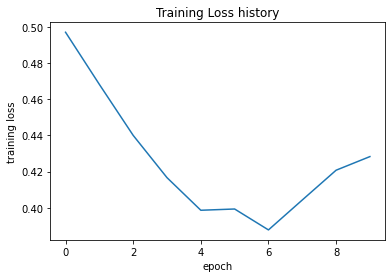

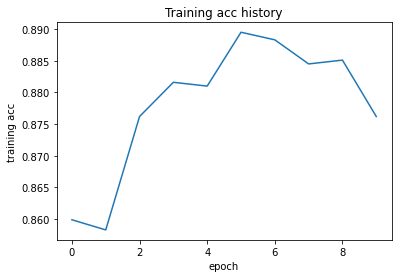

In [12]:
model = TwoLayerModel(128)
L, acc = model.train(X_train, y_train, reg=1e-4)
plt.plot(L)
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()
plt.plot(acc)
plt.xlabel('epoch')
plt.ylabel('training acc')
plt.title('Training acc history')
plt.show()

In [6]:
predict = model.predict(X_test)
test_acc = (predict == y_test).mean()
print(f"acc:{test_acc}")

acc:0.8477


C:\Users\99480\AppData\Local\Temp\ipykernel_15332\1954188261.py:14: RuntimeWarning: overflow encountered in exp
  o_1 = 1 / (1 + np.exp(-Y_1))
C:\Users\99480\AppData\Local\Temp\ipykernel_15332\3395470305.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.astype(np.float)


In [26]:
model.save('model.txt')

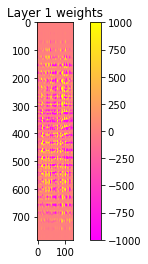

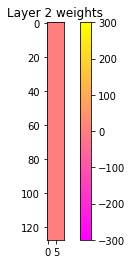

In [25]:
plt.figure(1)
plt.imshow(model.params['W1'], cmap='spring', vmin=-1000, vmax=1000)
plt.title('Layer 1 weights')
plt.colorbar()
plt.show()
plt.figure(1)
plt.imshow(model.params['W2'], cmap='spring', vmin=-300, vmax=300)
plt.title('Layer 2 weights')
plt.colorbar()
plt.show()